# Create summary plots for locations

This notebook is for creating some summmary plots for the various locations of interest.

The goal is to create barplots of four variables (indices) we have summarized over eras and decades:
* Hot day
* Cold day
* Maximum single day precipitation
* Heavy snow days

The barplots will show different types of summaries of the above indices across different time spans (main bars) as well as between-model variation (whiskers). The different types of summaries could be either mean or max, for now.

## Plotting

Run this cell first to set up the environment:

In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
# project
from config import *


# for runtime warning that is happening in DataFrame.plot() 
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# for user warning with pyplot.tight_layout plus added axis
warnings.simplefilter(action='ignore', category=UserWarning)

### Eras

This section will create barplots by era, with era on the x-axis. These will have much smaller widths compared to decadal plots because there are only three eras instead of 12 decades, so we will combine some of the indices into the same plot.

Note - at the time of creating these, only "Hot day" and "rx1day" were created, and only for two locations, and that was sufficient for their purpose (progress report). So that is all that is created here for now.

Define a function to summarize the data and create barplots by era:

In [2]:
# not sure of a better way to change legend title size atm
plt.rcParams["legend.title_fontsize"] = 14

def make_era_barplot(df, aggr_var, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes = axes.flatten()

    plot_lu = {
        "hd": {"title": "Hot day", "ylab": "°C",},
        "rx1day": {"title": "Rx1day", "ylab": "mm",},
    }
    colors = ["#1f77b4", "#ff7f0e"]

    for index, ax in zip(["hd", "rx1day"], axes):
        temp_df = (
            df[df["idx_var"] == index]
            .query("scenario != 'hist'") # historical scenario not used in these plots
            .groupby(["scenario", "era"])
            .agg({aggr_var: ["min", "mean", "max"]})
        )
        # drop column multiindex
        temp_df = temp_df.droplevel(0, axis=1).reset_index()
        avg_df = temp_df.pivot(index="era", columns="scenario", values="mean")
        # error bar limits
        ll = (avg_df - temp_df.pivot(index="era", columns="scenario", values="min")).to_numpy().T
        ul = (temp_df.pivot(index="era", columns="scenario", values="max") - avg_df).to_numpy().T
        # holy moly figuring this out was hard-fought. yuck.
        err = np.array([
            [ll[0], ul[0]], #rcp45 limits 
            [ll[1], ul[1]], #rcp85 limits
        ])
        
        avg_df.plot(
            kind="bar", rot=0, yerr=err, ax=ax, capsize=5, legend=False, color=colors
        )  # .legend(loc="upper left")
        ax.set_ylabel(plot_lu[index]["ylab"], size=14, rotation=0, labelpad=15)
        ax.set_xlabel("Era", size=14)
        ax.set_title((f"{plot_lu[index]['title']}"), size=14)

    leg_ax = fig.add_axes([0.96, 0.2, 0.02, 0.7])
    handles = [
        mpatches.Patch(color=colors[0], label="RCP 4.5"),
        mpatches.Patch(color=colors[1], label="RCP 8.5"),
    ]
    leg_ax.set_axis_off()
    # Add legend to bottom-right ax
    leg_ax.legend(handles=handles, loc="center", fontsize=14, title="Scenario")
    fig.suptitle(title, size=16, y=1)
    

title_str = "{} extremes by era across all models for {}, AK"
tmp_fn = "{}_extremes_barplot_{}.png"

#### Mean indices

Plots of mean values of Hot day and Rx1day indices.

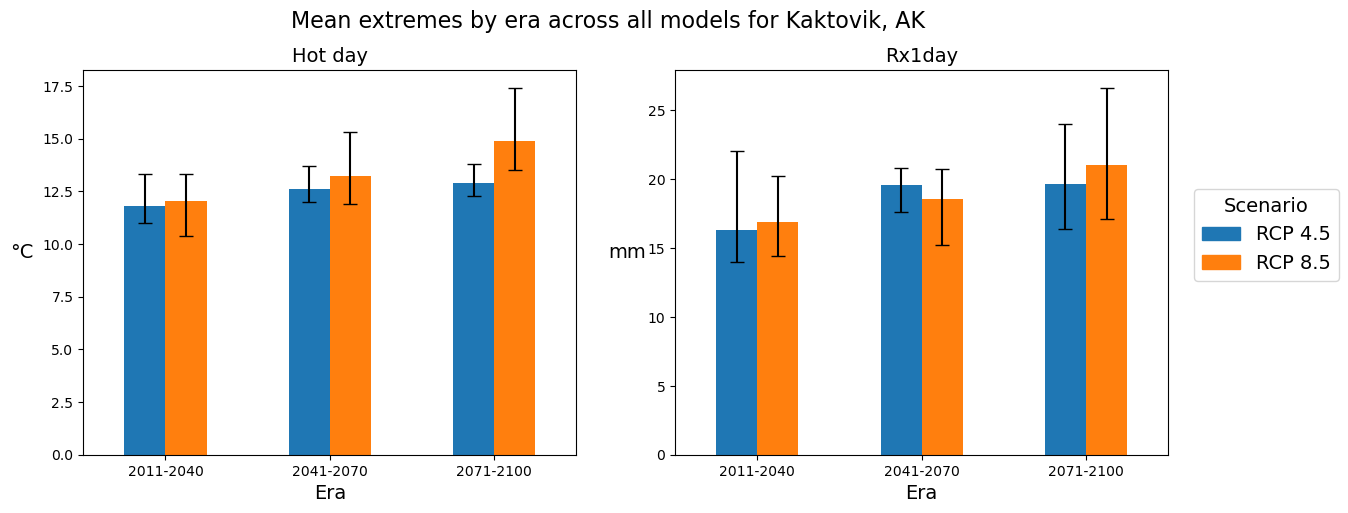

In [3]:
location = "Kaktovik"
df = pd.read_excel(idx_era_summary_fp, location) 
make_era_barplot(df, "mean", title_str.format("Mean", location))
out_fp = aux_dir.joinpath(tmp_fn.format("mean", location))
plt.savefig(out_fp, bbox_inches='tight', facecolor="white")

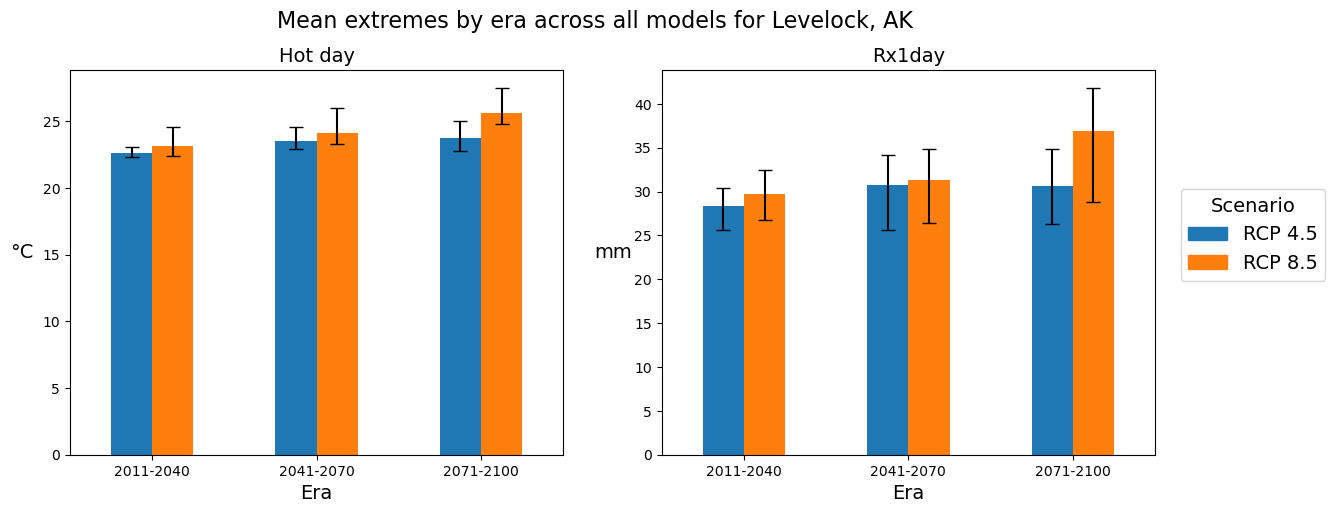

In [4]:
location = "Levelock"
df = pd.read_excel(idx_era_summary_fp, location) 
make_era_barplot(df, "mean", title_str.format("Mean", location))
out_fp = aux_dir.joinpath(tmp_fn.format("mean", location))
plt.savefig(out_fp, bbox_inches='tight', facecolor="white")

### Maximum indices

Plots of maximum values of Hot day and Rx1day indices.

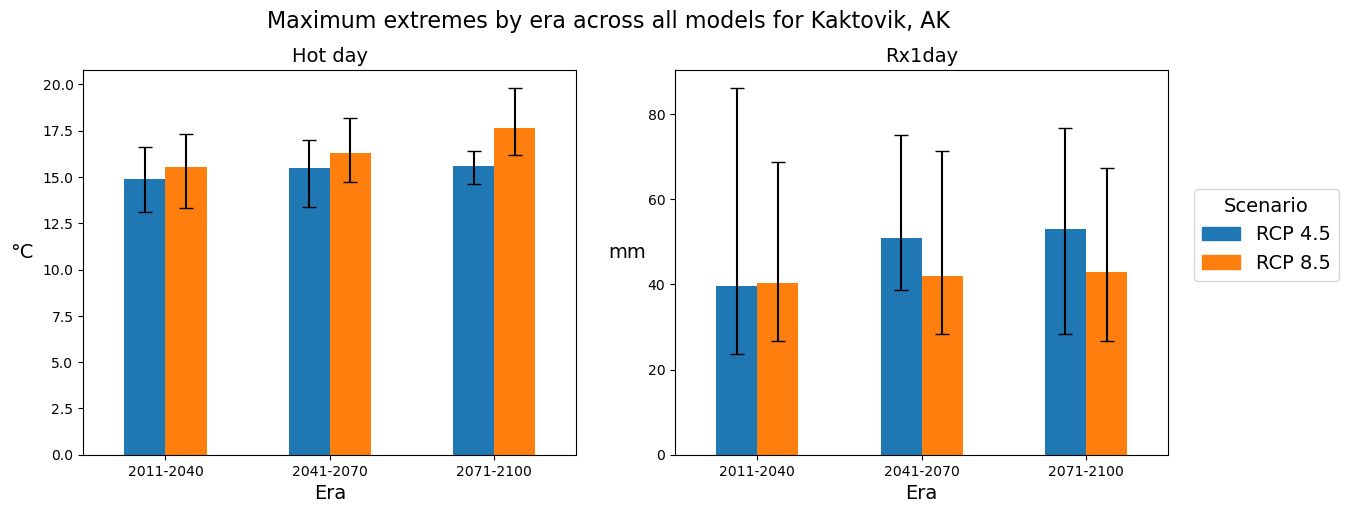

In [5]:
location = "Kaktovik"
df = pd.read_excel(idx_era_summary_fp, location) 
make_era_barplot(df, "max", title_str.format("Maximum", location))
out_fp = aux_dir.joinpath(tmp_fn.format("max", location))
plt.savefig(out_fp, bbox_inches='tight', facecolor="white")

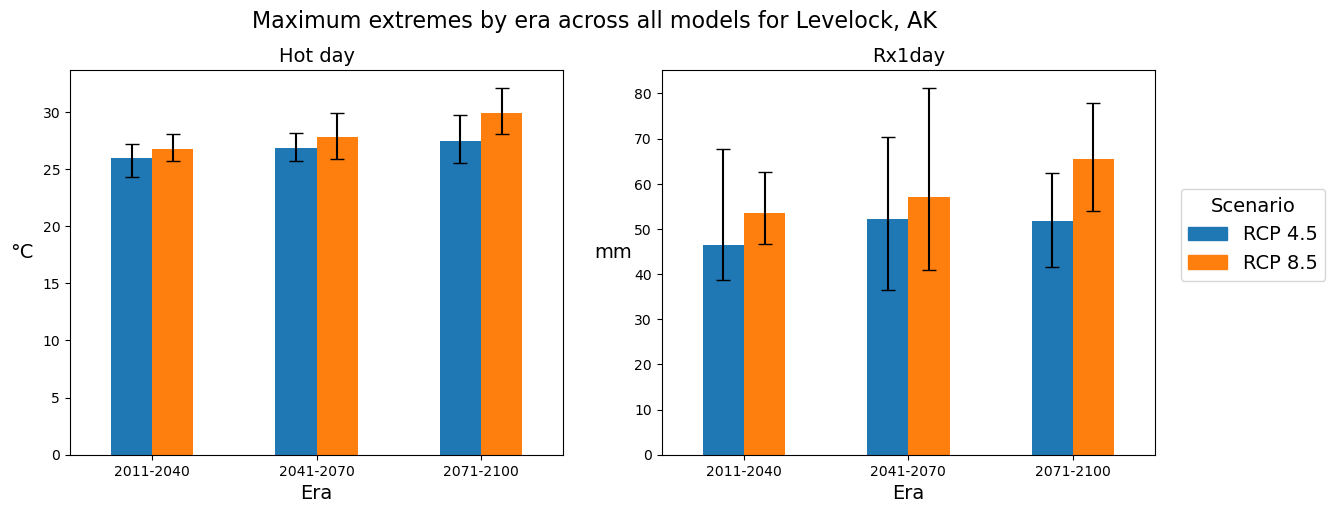

In [6]:
location = "Levelock"
df = pd.read_excel(idx_era_summary_fp, location) 
make_era_barplot(df, "max", title_str.format("Maximum", location))
out_fp = aux_dir.joinpath(tmp_fn.format("max", location))
plt.savefig(out_fp, bbox_inches='tight', facecolor="white")

### Decadal summary plots

This section will create barplots by decade, and differs from the era section slightly due to the requested deliverable. The main differences are that plots for all locations are created here, for all four indices listed at the beginning of the notebook (instead of just two). This is only done for the mean aggregation though, not the maximum.

Define a function to create a barplot from a dataframe of decadal summaries of the indices. Similar to the era function, but is wide enough to have a reasonably-sized plot for just one index.

In [7]:
# not sure of a better way to change legend title size atm
plt.rcParams["legend.title_fontsize"] = 14

def make_decade_barplot(df, index, aggr_var, title, ylab):
    colors = ["#d2b48c", "#1f77b4", "#ff7f0e"]
     
    temp_df = (
        df[df["idx_var"] == index]
        .groupby(["scenario", "decade"])
        .agg({aggr_var: ["min", "mean", "max"]})
    )
    
    if len(np.unique(temp_df["mean"])) < 5:
        print(f"No meaningful variation, skipping location: {' '.join(title.split()[-2:])}, var: {index}")
        return "skip"

    # drop column multiindex
    temp_df = temp_df.droplevel(0, axis=1).reset_index()
    avg_df = temp_df.pivot(index="decade", columns="scenario", values="mean")
    # error bar limits
    ll = (avg_df - temp_df.pivot(index="decade", columns="scenario", values="min")).to_numpy().T
    ul = (temp_df.pivot(index="decade", columns="scenario", values="max") - avg_df).to_numpy().T
    err = np.array([
        [ll[0], ul[0]], #hist limits 
        [ll[1], ul[1]], #rcp45 limits 
        [ll[2], ul[2]], #rcp85 limits
    ])
    fig, ax = plt.subplots(1, figsize=(14, 7))
    avg_df.plot(
        kind="bar", rot=0, yerr=err, ax=ax, capsize=5, legend=False, color=colors, width=1,
    )  # .legend(loc="upper left")

    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel(ylab, size=14, rotation=0, labelpad=15)
    ax.set_xlabel("Decade", size=14)
    leg_ax = fig.add_axes([1.05, 0.2, 0.02, 0.7])
    handles = [
        mpatches.Patch(color=colors[0], label="Historical"),
        mpatches.Patch(color=colors[1], label="RCP 4.5"),
        mpatches.Patch(color=colors[2], label="RCP 8.5"),
    ]
    leg_ax.set_axis_off()
    # Add legend to bottom-right ax
    leg_ax.legend(handles=handles, loc="center", fontsize=14, title="Scenario")
    fig.suptitle(title, size=16)
    plt.tight_layout()

Set up some strings for help with plotting and saving:

In [8]:
tmp_fn = "barplot_{}_{}_{}.png"
title_template = "Mean {} by decade across all models for {}, AK"
plot_lu = {
    "hd": {"title": "Hot day", "ylab": "°C",},
    "rx1day": {"title": "Rx1day", "ylab": "mm",},
    "cd": {"title": "Cold day", "ylab": "°C",},
    "hsd": {"title": "Heavy snow days", "ylab": "Count",},
}

And iterate over locations and indices and plot:

In [9]:
for location in locations:
    df = pd.read_excel(idx_decade_summary_fp, location, engine="openpyxl") 
    for index in np.unique(df["idx_var"].values):
        title_str = title_template.format(plot_lu[index]["title"], location)
        ylab = plot_lu[index]["ylab"]
        out = make_decade_barplot(df, index, "mean", title_str, ylab)
        if out == "skip":
            continue
        out_fp = decadal_summary_dir.joinpath(tmp_fn.format("mean", index, location))
        plt.savefig(out_fp, bbox_inches='tight', facecolor="white")
        plt.close()
    print(f"{location} done")

No meaningful variation, skipping location: Kaktovik, AK, var: hsd
Kaktovik done
No meaningful variation, skipping location: Village, AK, var: hsd
Stevens Village done
No meaningful variation, skipping location: Village, AK, var: hsd
Igiugik Village done
No meaningful variation, skipping location: Levelock, AK, var: hsd
Levelock done
Eyak done
Ketchikan done
No meaningful variation, skipping location: Aleutians, AK, var: hsd
Aleutians done


Note - we do not print out the figures to the notebook here because there are many!

Verify the new plots were created:

In [10]:
ls -l $decadal_summary_dir/

total 1180
-rw-rw-r--. 1 kmredilla snap_users 49193 Sep 28 17:39 barplot_mean_cd_Aleutians.png
-rw-rw-r--. 1 kmredilla snap_users 49529 Sep 28 17:39 barplot_mean_cd_Eyak.png
-rw-rw-r--. 1 kmredilla snap_users 47931 Sep 28 17:39 barplot_mean_cd_Igiugik Village.png
-rw-rw-r--. 1 kmredilla snap_users 47261 Sep 28 17:39 barplot_mean_cd_Kaktovik.png
-rw-rw-r--. 1 kmredilla snap_users 44752 Sep 28 17:39 barplot_mean_cd_Ketchikan.png
-rw-rw-r--. 1 kmredilla snap_users 46999 Sep 28 17:39 barplot_mean_cd_Levelock.png
-rw-rw-r--. 1 kmredilla snap_users 49266 Sep 28 17:39 barplot_mean_cd_Stevens Village.png
-rw-rw-r--. 1 kmredilla snap_users 47973 Sep 28 17:39 barplot_mean_hd_Aleutians.png
-rw-rw-r--. 1 kmredilla snap_users 44521 Sep 28 17:39 barplot_mean_hd_Eyak.png
-rw-rw-r--. 1 kmredilla snap_users 44609 Sep 28 17:39 barplot_mean_hd_Igiugik Village.png
-rw-rw-r--. 1 kmredilla snap_users 47071 Sep 28 17:39 barplot_mean_hd_Kaktovik.png
-rw-rw-r--. 1 kmredilla snap_users 47164 Sep 28 17:39 barplo